In [1]:
import pandas as pd
import numpy as np
import json  # Para parsear .geo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
# Definir rangos de años
years = range(2000, 2025)  # De 2000 a 2024 inclusive

# Listas para acumular dataframes procesados
modis_list = []
no_incendios_list = []

# Loop para cargar y procesar modis (incendios positivos)
for year in years:
    modis_file = f'Incendios/modis_{year}_Peru.csv'
    if os.path.exists(modis_file):
        modis_df_year = pd.read_csv(modis_file)

        # Filtrar a región de San Martín
        san_martin_modis_year = modis_df_year[
            (modis_df_year['latitude'] >= -8) & (modis_df_year['latitude'] <= -5) &
            (modis_df_year['longitude'] >= -78) & (modis_df_year['longitude'] <= -75)
        ].copy() # <-- .copy() evita el warning

        san_martin_modis_year['incendio'] = 1
        san_martin_modis_year = san_martin_modis_year[['acq_date', 'latitude', 'longitude', 'incendio']]
        modis_list.append(san_martin_modis_year)
    else:
        print(f"Archivo no encontrado: {modis_file}")

# Loop para cargar y procesar no_incendios (negativos)
for year in years:
    no_incendios_file = f'NoIncendios/puntos_sin_incendio_sanmartin_{year}.csv'
    if os.path.exists(no_incendios_file):
        no_incendios_df_year = pd.read_csv(no_incendios_file)

        # Parsear .geo para extraer lon y lat
        no_incendios_df_year['longitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][0])
        no_incendios_df_year['latitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][1])
        no_incendios_df_year['incendio'] = 0
        no_incendios_df_year = no_incendios_df_year[['acq_date', 'latitude', 'longitude', 'incendio']]
        no_incendios_list.append(no_incendios_df_year)
    else:
        print(f"Archivo no encontrado: {no_incendios_file}")

# Combinar todos los dataframes
all_modis = pd.concat(modis_list, ignore_index=True) if modis_list else pd.DataFrame()
all_no_incendios = pd.concat(no_incendios_list, ignore_index=True) if no_incendios_list else pd.DataFrame()
full_df = pd.concat([all_modis, all_no_incendios], ignore_index=True)

# Ver totales
print(f"Total incendios: {len(all_modis)}")
print(f"Total no incendios: {len(all_no_incendios)}")
print(f"Dataset completo: {len(full_df)}")
full_df.head()

Total incendios: 75765
Total no incendios: 45314
Dataset completo: 121079


,acq_date,latitude,longitude,incendio
0,2000-11-02,-6.6777,-77.7984,1
1,2000-11-04,-5.8207,-77.3019,1
2,2000-11-04,-6.1100,-77.7796,1
3,2000-11-04,-6.1147,-77.7732,1
4,2000-11-04,-7.4112,-77.6202,1


In [3]:
# Convertir acq_date a datetime
full_df['acq_date'] = pd.to_datetime(full_df['acq_date'], errors='coerce')
full_df = full_df.dropna(subset=['acq_date'])

# Extraer features temporales
full_df['year'] = full_df['acq_date'].dt.year
full_df['month'] = full_df['acq_date'].dt.month
full_df['day'] = full_df['acq_date'].dt.day
full_df['day_of_year'] = full_df['acq_date'].dt.dayofyear

full_df.head()

,acq_date,latitude,longitude,incendio,year,month,day,day_of_year
0,2000-11-02,-6.6777,-77.7984,1,2000,11,2,307
1,2000-11-04,-5.8207,-77.3019,1,2000,11,4,309
2,2000-11-04,-6.1100,-77.7796,1,2000,11,4,309
3,2000-11-04,-6.1147,-77.7732,1,2000,11,4,309
4,2000-11-04,-7.4112,-77.6202,1,2000,11,4,309


In [4]:
features = ['latitude', 'longitude', 'month', 'day', 'day_of_year', 'year']
X = full_df[features]
y = full_df['incendio']

print(y.value_counts())

incendio
1    75765
0    45314
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Crear modelo
model = DecisionTreeClassifier(
    class_weight='balanced',  # <-- Manejo de desbalance
    max_depth=8,              # <-- ¡CLAVE! Limita el árbol para evitar sobreajuste
    random_state=42
)

# Entrenar el modelo (con los datos originales, SIN escalar)
model.fit(X_train, y_train)

print("Modelo de Árbol de Decisión entrenado.")

# Predecir en test
y_pred = model.predict(X_test)

Modelo de Árbol de Decisión entrenado.


Accuracy: 0.854187314172448

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      9063
           1       0.90      0.86      0.88     15153

    accuracy                           0.85     24216
   macro avg       0.84      0.85      0.85     24216
weighted avg       0.86      0.85      0.86     24216


--- Matriz de Confusión ---


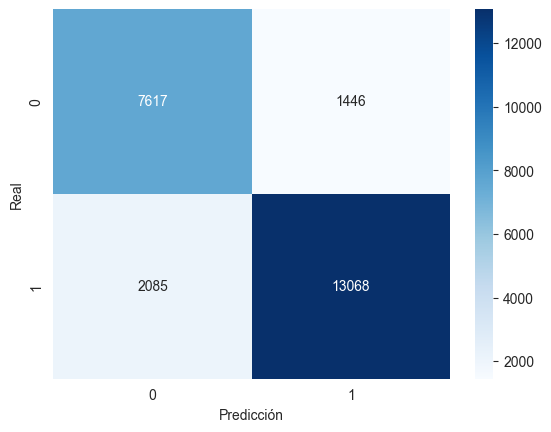


--- Importancia de Features ---
       feature    importance
4  day_of_year  5.548201e-01
1    longitude  2.602485e-01
0     latitude  1.372264e-01
5         year  4.742735e-02
3          day  2.776838e-04
2        month  2.135057e-14


C:\Users\User\AppData\Local\Temp\ipykernel_9796\1606893230.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


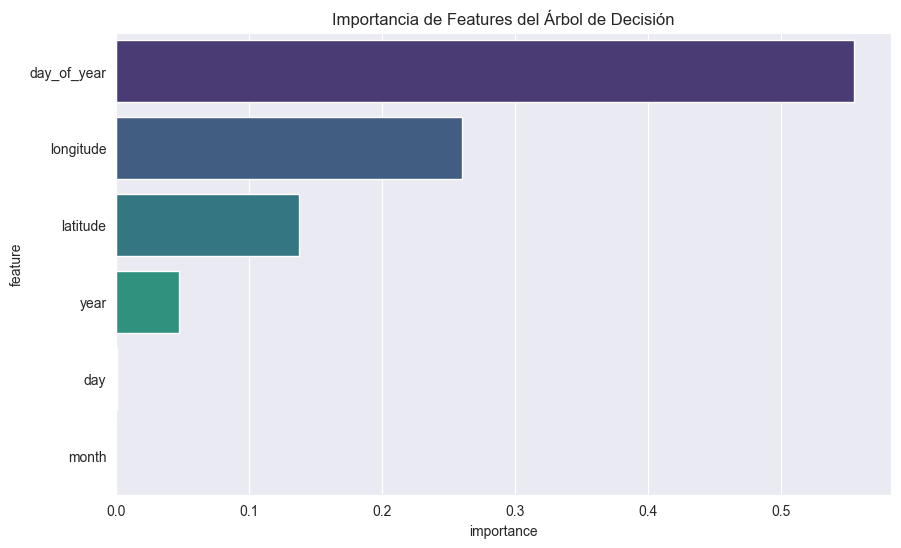


--- Visualización del Árbol (primeros 3 niveles) ---


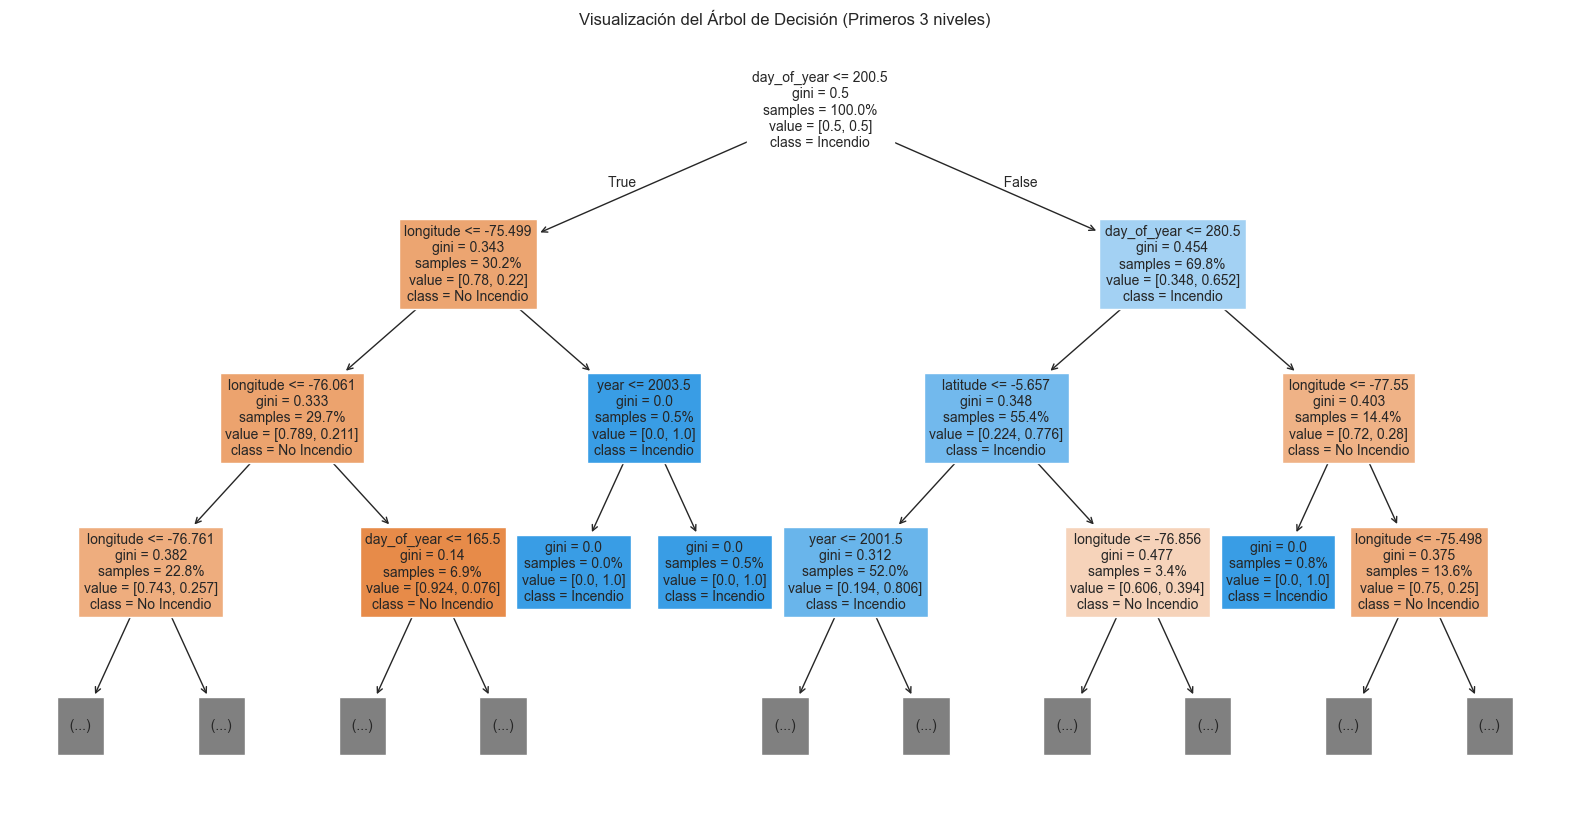

In [7]:
# --- 1. Métricas de siempre ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# --- 2. Matriz de confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# --- 3. Importancia de Features ---
print("\n--- Importancia de Features ---")
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title('Importancia de Features del Árbol de Decisión')
plt.show()

# --- 4. ¡Visualización del Árbol! ---
# Graficamos solo los primeros 3 niveles (max_depth=3) para que sea legible.
# Si no, un árbol con profundidad 8 sería un jeroglífico.
print("\n--- Visualización del Árbol (primeros 3 niveles) ---")
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=features,
    class_names=['No Incendio', 'Incendio'],
    filled=True,
    proportion=True,
    max_depth=3,  # <-- Limita EL DIBUJO, no el modelo
    fontsize=10
)
plt.title("Visualización del Árbol de Decisión (Primeros 3 niveles)")
plt.show()

In [ ]:
# Guardar el modelo
joblib.dump(model, 'decision_tree_incendios_model.joblib')

print("Modelo de Árbol de Decisión guardado.")